# LSTM

- SentimentText를 X로, Aspect를 y로 학습시킴

## Set

In [40]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import platform
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Load Data

### cosmetics

In [5]:
path = "../../data/raw/"
df_cosmetics = pd.read_csv(path+"cosmetics.csv", sep = ',', encoding = 'utf-8', header = 0)
df_cosmetics.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,기능/효과,올 겨울은 촉촉하게 보내고 있어 좋습니다.,6,1
1,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,보습력/수분감/쿨링감,촉촉하게,1,1
2,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,용기,"케이스는 이쁜데,",2,1
3,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,용량/개수,양이 적어서,2,-1
4,660038,발림성 좋습니다. 지속력 좋네요. 건조해진 입술 살짝 발라줬는데 금방 촉촉해져서 좋...,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,86,20,20171121,1.0,발림성,발림성 좋습니다.,2,1


In [6]:
df_cosmetics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150318 entries, 0 to 150317
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              150318 non-null  int64  
 1   RawText            150318 non-null  object 
 2   Source             150318 non-null  object 
 3   Domain             150318 non-null  object 
 4   MainCategory       150318 non-null  object 
 5   ProductName        150316 non-null  object 
 6   ReviewScore        150318 non-null  int64  
 7   Syllable           150318 non-null  int64  
 8   Word               150318 non-null  int64  
 9   RDate              150318 non-null  int64  
 10  GeneralPolarity    148644 non-null  float64
 11  Aspect             150318 non-null  object 
 12  SentimentText      150318 non-null  object 
 13  SentimentWord      150318 non-null  int64  
 14  SentimentPolarity  150318 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 17

In [8]:
df_cosmetics['Aspect'].nunique()

44

In [28]:
df_cosmetics['Aspect'].unique()

array(['기능/효과', '보습력/수분감/쿨링감', '용기', '용량/개수', '발림성', '지속력/유지력', '흡수력',
       '향', '편의성/활용성', '발색력', '가격', '제품구성', '자극성', '윤기/피부(톤)', '디자인',
       '품질', '유통기한', '밀착력/접착력', '색상', '제형', '사이즈/두께', '용량', '보습력/수분감',
       '사용감', '피부타입', '성분', '지속력', '탄력', '커버력', '머릿결관리', '염색력', '이염',
       '용량/사이즈', '향/냄새', '스타일링효과', '클렌징/제거력', '세팅력/고정력', '청량감/쿨링감',
       '두피보호', '탈모개선', '세정력', '거품력', '분사력', '그립감'], dtype=object)

In [7]:
df_cosmetics['Aspect'].value_counts()

기능/효과          16934
가격             13196
보습력/수분감        11269
향              10377
편의성/활용성         9422
흡수력             8848
발림성             6656
향/냄새            5947
지속력/유지력         5453
제품구성            5310
윤기/피부(톤)        4927
자극성             4719
보습력/수분감/쿨링감     4222
색상              3421
제형              3341
머릿결관리           3089
발색력             2833
용기              2443
염색력             2363
용량              2287
커버력             1985
품질              1943
피부타입            1803
밀착력/접착력         1677
유통기한            1651
용량/사이즈          1564
사용감             1115
성분              1052
청량감/쿨링감         1049
탈모개선            1010
스타일링효과           976
용량/개수            959
세정력              909
세팅력/고정력          904
지속력              895
탄력               870
사이즈/두께           720
거품력              687
디자인              485
이염               347
클렌징/제거력          304
두피보호             249
분사력              100
그립감                7
Name: Aspect, dtype: int64

### garments

In [9]:
df_garments = pd.read_csv(path+"garments.csv", sep = ',', encoding = 'utf-8', header = 0)
df_garments.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,불편하고,1,-1
1,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,활동하기 안좋다고 잘 안입고 다니네요,5,-1
2,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,너무불편하다고상품이별로래요.,1,-1
3,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,불편해서자주입을것같지는 않데요.,2,-1
4,128484,이번에구매한데님은사이즈가잘맞네요 색상구성도괜찮고맘에든답니다 잘입겠습니다,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,39,3,20180315,1.0,사이즈,사이즈가잘맞네요,1,1


In [10]:
df_garments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152143 entries, 0 to 152142
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              152143 non-null  int64  
 1   RawText            152143 non-null  object 
 2   Source             152143 non-null  object 
 3   Domain             152143 non-null  object 
 4   MainCategory       152143 non-null  object 
 5   ProductName        152125 non-null  object 
 6   ReviewScore        152143 non-null  int64  
 7   Syllable           152143 non-null  int64  
 8   Word               152143 non-null  int64  
 9   RDate              152143 non-null  int64  
 10  GeneralPolarity    149774 non-null  float64
 11  Aspect             152143 non-null  object 
 12  SentimentText      152143 non-null  object 
 13  SentimentWord      152143 non-null  int64  
 14  SentimentPolarity  152143 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 17

In [12]:
df_garments['Aspect'].nunique()

27

In [29]:
df_garments['Aspect'].unique()

array(['착용감', '사이즈', '색상', '핏', '신축성', '마감', '가격', '디자인', '품질', '제품구성',
       '두께', '기능', '무게', '길이', '소재', '활용성', '촉감', '냄새', '사용성/편의성', '내구성',
       '기능성', '사이즈/폭/길이/두께', '수납', '치수/사이즈', '착화감', '사용성', '굽'],
      dtype=object)

In [16]:
df_garments['Aspect'].value_counts()

디자인            16353
사이즈            14163
가격             13616
품질             11799
착화감            10667
기능             10492
소재             10312
색상              8965
착용감             8154
치수/사이즈          5985
무게              5664
핏               5621
길이              4305
신축성             4228
두께              3924
활용성             3368
촉감              2499
제품구성            1811
기능성             1810
사이즈/폭/길이/두께     1712
사용성             1545
마감              1517
사용성/편의성         1154
내구성             1016
굽                674
냄새               524
수납               265
Name: Aspect, dtype: int64

### home_appliances

In [19]:
df_home_appliances = pd.read_csv(path+"home_appliances.csv", sep = ',', encoding = 'utf-8', header = 0)
df_home_appliances.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,기능,진동은 강한데 이물질은 잘 빠지지 않아서 그닥,7,0
1,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,사이즈,칫솔모도 너무 작아서 저한테는 별로예요,5,-1
2,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,기능,일주일째 쓰고 있는데 진동은 강합니다.,5,1
3,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,조작성,이물질은 빠지지는 않네요.,3,-1
4,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,편의성,칫솔질 하는 것보단 편하김 해요,5,1


In [20]:
df_home_appliances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111730 entries, 0 to 111729
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              111730 non-null  int64  
 1   RawText            111730 non-null  object 
 2   Source             111730 non-null  object 
 3   Domain             111730 non-null  object 
 4   MainCategory       111730 non-null  object 
 5   ProductName        111730 non-null  object 
 6   ReviewScore        111730 non-null  int64  
 7   Syllable           111730 non-null  int64  
 8   Word               111730 non-null  int64  
 9   RDate              111730 non-null  int64  
 10  GeneralPolarity    90018 non-null   float64
 11  Aspect             111730 non-null  object 
 12  SentimentText      111730 non-null  object 
 13  SentimentWord      111730 non-null  int64  
 14  SentimentPolarity  111730 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 12

In [21]:
df_home_appliances['Aspect'].nunique()

20

In [30]:
df_home_appliances['Aspect'].unique()

array(['기능', '사이즈', '조작성', '편의성', '품질', '가격', '디자인', '용량', '제품구성', '소음',
       '내구성', '무게', '배터리', '제조일/제조사', '시간/속도', '소재', '색상', '소비전력',
       '음량/음질', '화질'], dtype=object)

In [22]:
df_home_appliances['Aspect'].value_counts()

기능         26480
가격         12004
편의성         9980
디자인         9614
소음          8799
품질          6290
조작성         5332
사이즈         5305
색상          4305
음량/음질       3966
용량          3360
무게          3003
제품구성        2832
제조일/제조사     2612
화질          2047
시간/속도       1731
소비전력        1199
내구성         1143
소재          1051
배터리          677
Name: Aspect, dtype: int64

### tech_devices

In [24]:
df_tech_devices = pd.read_csv(path+"tech_devices.csv", sep = ',', encoding = 'utf-8', header = 0)
df_home_appliances.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,기능,진동은 강한데 이물질은 잘 빠지지 않아서 그닥,7,0
1,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,사이즈,칫솔모도 너무 작아서 저한테는 별로예요,5,-1
2,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,기능,일주일째 쓰고 있는데 진동은 강합니다.,5,1
3,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,조작성,이물질은 빠지지는 않네요.,3,-1
4,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,편의성,칫솔질 하는 것보단 편하김 해요,5,1


In [25]:
df_tech_devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100823 entries, 0 to 100822
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              100823 non-null  int64  
 1   RawText            100823 non-null  object 
 2   Source             100823 non-null  object 
 3   Domain             100823 non-null  object 
 4   MainCategory       100823 non-null  object 
 5   ProductName        100823 non-null  object 
 6   ReviewScore        100823 non-null  int64  
 7   Syllable           100823 non-null  int64  
 8   Word               100823 non-null  int64  
 9   RDate              100823 non-null  int64  
 10  GeneralPolarity    88027 non-null   float64
 11  Aspect             100823 non-null  object 
 12  SentimentText      100823 non-null  object 
 13  SentimentWord      100823 non-null  int64  
 14  SentimentPolarity  100823 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 11

In [26]:
df_tech_devices['Aspect'].nunique()

20

In [31]:
df_tech_devices['Aspect'].unique()

array(['사이즈', '기능', '가격', '시간/속도', '편의성', '품질', '제품구성', '무게', '용량', '화질',
       '색상', '디자인', '배터리', '제조일/제조사', '조작성', '음량/음질', '내구성', '소재', '소음',
       '소비전력'], dtype=object)

In [27]:
df_tech_devices['Aspect'].value_counts()

가격         13919
기능         11687
편의성         7774
사이즈         7205
조작성         7019
품질          6714
음량/음질       6596
디자인         6142
색상          5495
화질          4817
제품구성        4621
무게          4241
제조일/제조사     3594
시간/속도       3414
배터리         2094
소음          1793
내구성         1602
용량          1156
소재           893
소비전력          47
Name: Aspect, dtype: int64

## Categorizing

### cosmetics

In [ ]:
categories = {
    "price": ["가격"],
    "composition": ["제품구성", "성분"],
    "usability": ["거품력", "발림성", "분사력", "사용감", "세정력", "자극성", "제형", "클렌징/제거력"],
    "packaging": ["그립감", "디자인", "사이즈/두께", "색상", "용기", "용량", "용량/개수", "용량/사이즈", "유통기한", "편의성/활용성"],
    "quality": ["밀착력/접착력", "발색력", "보습력/수분감", "보습력/수분감/쿨링감", "이염", "품질", "향", "향/냄새", "흡수력"],
    "effectiveness": ["기능/효과", "세팅력/고정력", "염색력", "지속력", "지속력/유지력", "청량감/쿨링감", "커버력", "두피보호", "머릿결관리", "스타일링효과", "윤기/피부(톤)", "탄력", "탈모개선", "피부타입"]
}


### garments

In [ ]:
categories = {
    "size": ["사이즈", "핏", "두께", "길이", "사이즈/폭/길이/두께", "치수/사이즈", "굽"],
    "design": ["색상", "디자인"],
    "quality": ["마감", "품질", "소재", "촉감", "냄새", "내구성"],
    "usability": ["사용성/편의성", "사용성", "수납", "활용성", "제품구성", "무게", "신축성", "기능", "기능성", "착화감", "착용감"],
    "price": ["가격"]
}

### home_appliances

In [ ]:
categories = {
    "price": ["가격"],
    "composition": ["제품구성"],
    "design": ["디자인", "색상"],
    "specification": ["무게", "배터리", "사이즈", "소비전력", "소재", "용량", "제조일/제조사"],
    "performance": ["기능", "내구성", "소음", "시간/속도", "음량/음질", "품질", "화질"],
    "usability": ["조작성", "편의성"]
}

### tech_devices

In [ ]:
categories = {}

## Top5 Aspect 학습 (SentimentText to Aspect)

### 패션 garments

In [34]:
df_garments = df_garments.dropna()
df_garments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149756 entries, 0 to 152142
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              149756 non-null  int64  
 1   RawText            149756 non-null  object 
 2   Source             149756 non-null  object 
 3   Domain             149756 non-null  object 
 4   MainCategory       149756 non-null  object 
 5   ProductName        149756 non-null  object 
 6   ReviewScore        149756 non-null  int64  
 7   Syllable           149756 non-null  int64  
 8   Word               149756 non-null  int64  
 9   RDate              149756 non-null  int64  
 10  GeneralPolarity    149756 non-null  float64
 11  Aspect             149756 non-null  object 
 12  SentimentText      149756 non-null  object 
 13  SentimentWord      149756 non-null  int64  
 14  SentimentPolarity  149756 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 18

In [35]:
df_garments['Aspect'].value_counts()[:6]

디자인    16177
사이즈    13793
가격     13450
품질     11627
착화감    10602
기능     10280
Name: Aspect, dtype: int64

In [36]:

# 착화감은 신발에만 해당되므로, 제외하고 top5 기준으로 데이터 추출
targets = ["디자인", "사이즈", "가격", "품질", "기능"]
target_df = df_garments.loc[df_garments["Aspect"].isin(targets), :]
target_df.head(2)

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
4,128484,이번에구매한데님은사이즈가잘맞네요 색상구성도괜찮고맘에든답니다 잘입겠습니다,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,39,3,20180315,1.0,사이즈,사이즈가잘맞네요,1,1
15,128494,바지는 너무 편하고 좋은데 좀크게나온듯 그리고 허리고리 하나가 안달려서 밑단수선하면...,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,60,118,24,20180317,0.0,사이즈,좀크게나온듯,1,-1


In [43]:
label_encoder = LabelEncoder()
enc_data = label_encoder.fit_transform(target_df['Aspect'])
num_labels = len(set(enc_data))

In [44]:
X, y = target_df.loc[:, "SentimentText"].to_list(), enc_data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [66]:
X_train

['디자인은 괜찮아요',
 '따뜻해요',
 '베스트 퀄리티가 좋네요',
 '가격도 좋고 ',
 '세탁후에도 털빠짐 있고 ㅜ',
 '롱패딩치고 a라인이라 그런지 여성스럽네요',
 '지금계절에입기딱이네요',
 '부채꼴모양의 클러치가 모양은 제일 제 취향인데',
 '깃에있는 버클고리가 끊어져서 왔습니다.',
 '옷이 모양이 풍성해서',
 '디자인이 깔끔하고 ',
 '크게 입고싶어서 라지샀는데 엑스라지 살걸 그랬어요',
 '디자인과 색상이 좋아요',
 '95사이즈가 없어서 100으로 주문했는데 예쁘게 잘 맞아요 ',
 '32 주문했는데 약간 크게 나왔습니다.',
 '하사이즈 작게 사도 될 듯 해요~^^',
 '갈색이힙둘레가3센치정도작더라구요',
 '품질 매우 만족합니다.',
 '엄청커고',
 '가격이 싸니 ',
 '가격만큼은 입을수있겠지요.^^',
 '가격대비 좋은 상품인것 같아요.',
 '세장다 다 디자인이 예쁘고',
 '생각보다 시원하진 않네요',
 '디자인 무난하게 입을 수 있어 만족해요',
 '디자인도 좋고  ',
 '저렴하게 잘 구매했습니다 ',
 '넘 예쁘게 잘 신어요~~',
 '원래 입던대로 주문 했는데.. 사이즈 잘 맞습니다...',
 '모양도 예쁘고',
 '사이즈도 잘 맞아서 좋네요^^',
 '정사이즈로 사거나 반사이즈는 사이즈 올리는게 좋을듯 해요.',
 '한치수 업해서',
 '한가지 바닥이 미끄러워요',
 '디자인이 발볼 태평양인 제게 부끄러움을 덜어줬네요 ',
 ' 밴드처리 되어있어',
 '세련되게 보여 좋아요..',
 '가죽 가방을  이 가격에  3개나  득템하여서 정말 만족합니다~',
 '좋은가격에 만들어주셔서고맙습니다^^♡',
 '품질도 좋아서',
 '싼게 비지떡이란 말이 생각나고 후회를 많이 했습니다.',
 ' 싼 맛에  대충 입겠지만',
 '품이엄척크네요.',
 '지금보다는 쬠 따뜻해지면 입어야할듯요',
 '세일 많이 해서 구매 했는데',
 '두개도 입어봤는데 사이즈가 너무너무 커서 못입을 정도네요',
 '좀 타이트하게 나온듯요. ',


In [67]:
y_train

array([2, 1, 4, ..., 4, 2, 0])

Tokenization

In [46]:
# Tokenization
def preprocessing(rawtext,okt,stem=False,remove_stopwords=False,stopwords=[]):
    # 1. 한글 및 공백 제외한 문자 모두 제거 
    rawtext = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',rawtext)
    rawtext = re.sub(r"[^가-힣A-Za-z)-9(),!?\'\`]", " ", rawtext)
    # 2. Okt 객체를 활용하여 형태소 단어로 나눔 / 어간 추출 (선택)
    word_text = okt.morphs(rawtext,stem=False)

    if stem:
        word_text = okt.morphs(rawtext,stem=True)
        
        if remove_stopwords:
            # 3. 불용어 제거 (선택)
            word_text = [token for token in word_text if not token in stopwords]          
        return word_text
        
    return word_text

In [47]:
okt = Okt()
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
# stopwords 근거 찾아보기
# stopwords = [‘의’,‘가’,‘이’,‘은’,‘들’,‘는’,‘좀’,‘잘’,‘걍’,‘과’,‘도’,‘를’,‘으로’,‘자’,‘에’,‘와’,‘한’,‘하다’,‘다’, ‘로’]

In [49]:
# preprocessing에서 가장 정확도가 높았던 Type 2 선택
clean_train_review_2 = []
clean_test_review_2 = []

for SentimentText in X_train:
    clean_train_review_2.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for SentimentText in X_test:
    clean_test_review_2.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_2[:4]

[['디자인', '은', '괜찮다'], ['따뜻하다'], ['베스트', '퀄리티', '가', '좋다'], ['가격', '도', '좋다']]

In [50]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_2 = [len(tokens) for tokens in clean_train_review_2]
df_tokens_len_2 = pd.DataFrame(tokens_len_2, columns=['Token Count'])
df_tokens_len_2.describe()

,Token Count
count,52261.000000
mean,5.253459
std,2.776958
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,26.000000


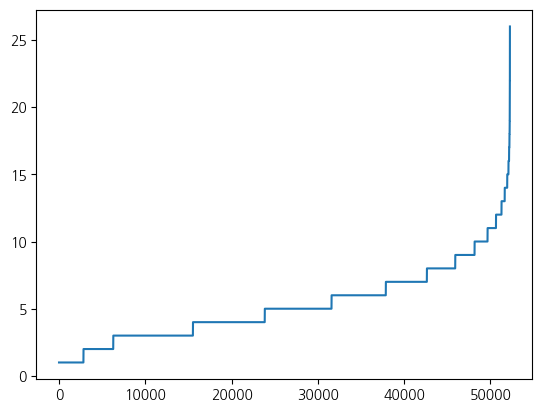

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline 

tokens_len_2.sort()
plt.plot(tokens_len_2)
plt.show()

In [62]:
max_sequence_length = 26
print(sum([int(l<=max_sequence_length) for l in tokens_len_2]))

52261


In [63]:
# 토큰 수 컨트롤
modified_clean_train_review_2 = [tokens[:max_sequence_length] for tokens in clean_train_review_2]
modified_clean_test_review_2 = [tokens[:max_sequence_length] for tokens in clean_test_review_2]

In [59]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_2)

X_train_2 = tokenizer.texts_to_sequences(modified_clean_train_review_2)
X_train_2 = pad_sequences(X_train_2, padding='post')

X_test_2 = tokenizer.texts_to_sequences(modified_clean_test_review_2)
X_test_2 = pad_sequences(X_test_2, padding ='post') 

print(X_train_2[:5])

[[  6  12  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [ 21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [530 166   8   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  2   7   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [126 280 143 122  91  22   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]


Modeling

In [64]:
# 모델 훈련
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=max_sequence_length),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 26, 300)           6000000   
                                                                 
 lstm_2 (LSTM)               (None, 50)                70200     
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 6070455 (23.16 MB)
Trainable params: 6070455 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
# 학습
history = model_2.fit(X_train_2, y_train, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3


327/327 [==============================] - 50s 138ms/step - loss: 0.5466 - accuracy: 0.7833 - val_loss: 0.2050 - val_accuracy: 0.9372
Epoch 2/3
327/327 [==============================] - 46s 140ms/step - loss: 0.1442 - accuracy: 0.9573 - val_loss: 0.1849 - val_accuracy: 0.9455
Epoch 3/3
327/327 [==============================] - 50s 152ms/step - loss: 0.0995 - accuracy: 0.9712 - val_loss: 0.1733 - val_accuracy: 0.9484


- 97%가 나왔지만, SentimentText로 validation한 것이므로 높게 나올 수밖에 없음